In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix


pd.set_option('display.max_columns', None)

In [3]:
rleads = pd.read_csv("Bank Leads Cleaned v2 20240119.csv")

In [4]:
rleads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68797 entries, 0 to 68796
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Gender                               68797 non-null  object 
 1   DOB                                  68797 non-null  object 
 2   Lead_Creation_Date                   68797 non-null  object 
 3   City_Code                            68797 non-null  object 
 4   City_Category                        68797 non-null  object 
 5   Employer_Category1                   68797 non-null  object 
 6   Employer_Category2                   68797 non-null  float64
 7   Monthly_Income                       68797 non-null  float64
 8   Customer_Existing_Primary_Bank_Code  68797 non-null  object 
 9   Primary_Bank_Type                    68797 non-null  object 
 10  Contacted                            68797 non-null  object 
 11  Source                      

# Drop less useful features

In [5]:
dleads = rleads.drop(["DOB", "City_Code", "Customer_Existing_Primary_Bank_Code", "Source", "DOB_Year", "Lead_Creation_Date", "Lead_Creation_Month", "Lead_Creation_Day", "Lead_Creation_Day_of_Week"], axis=1)

In [6]:
dleads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68797 entries, 0 to 68796
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              68797 non-null  object 
 1   City_Category       68797 non-null  object 
 2   Employer_Category1  68797 non-null  object 
 3   Employer_Category2  68797 non-null  float64
 4   Monthly_Income      68797 non-null  float64
 5   Primary_Bank_Type   68797 non-null  object 
 6   Contacted           68797 non-null  object 
 7   Source_Category     68797 non-null  object 
 8   Existing_EMI        68797 non-null  float64
 9   Loan_Amount         68797 non-null  float64
 10  Loan_Period         68797 non-null  float64
 11  Interest_Rate       68797 non-null  float64
 12  EMI                 68797 non-null  float64
 13  Var1                68797 non-null  int64  
 14  Approved            68797 non-null  int64  
 15  Age                 68797 non-null  int64  
dtypes: f

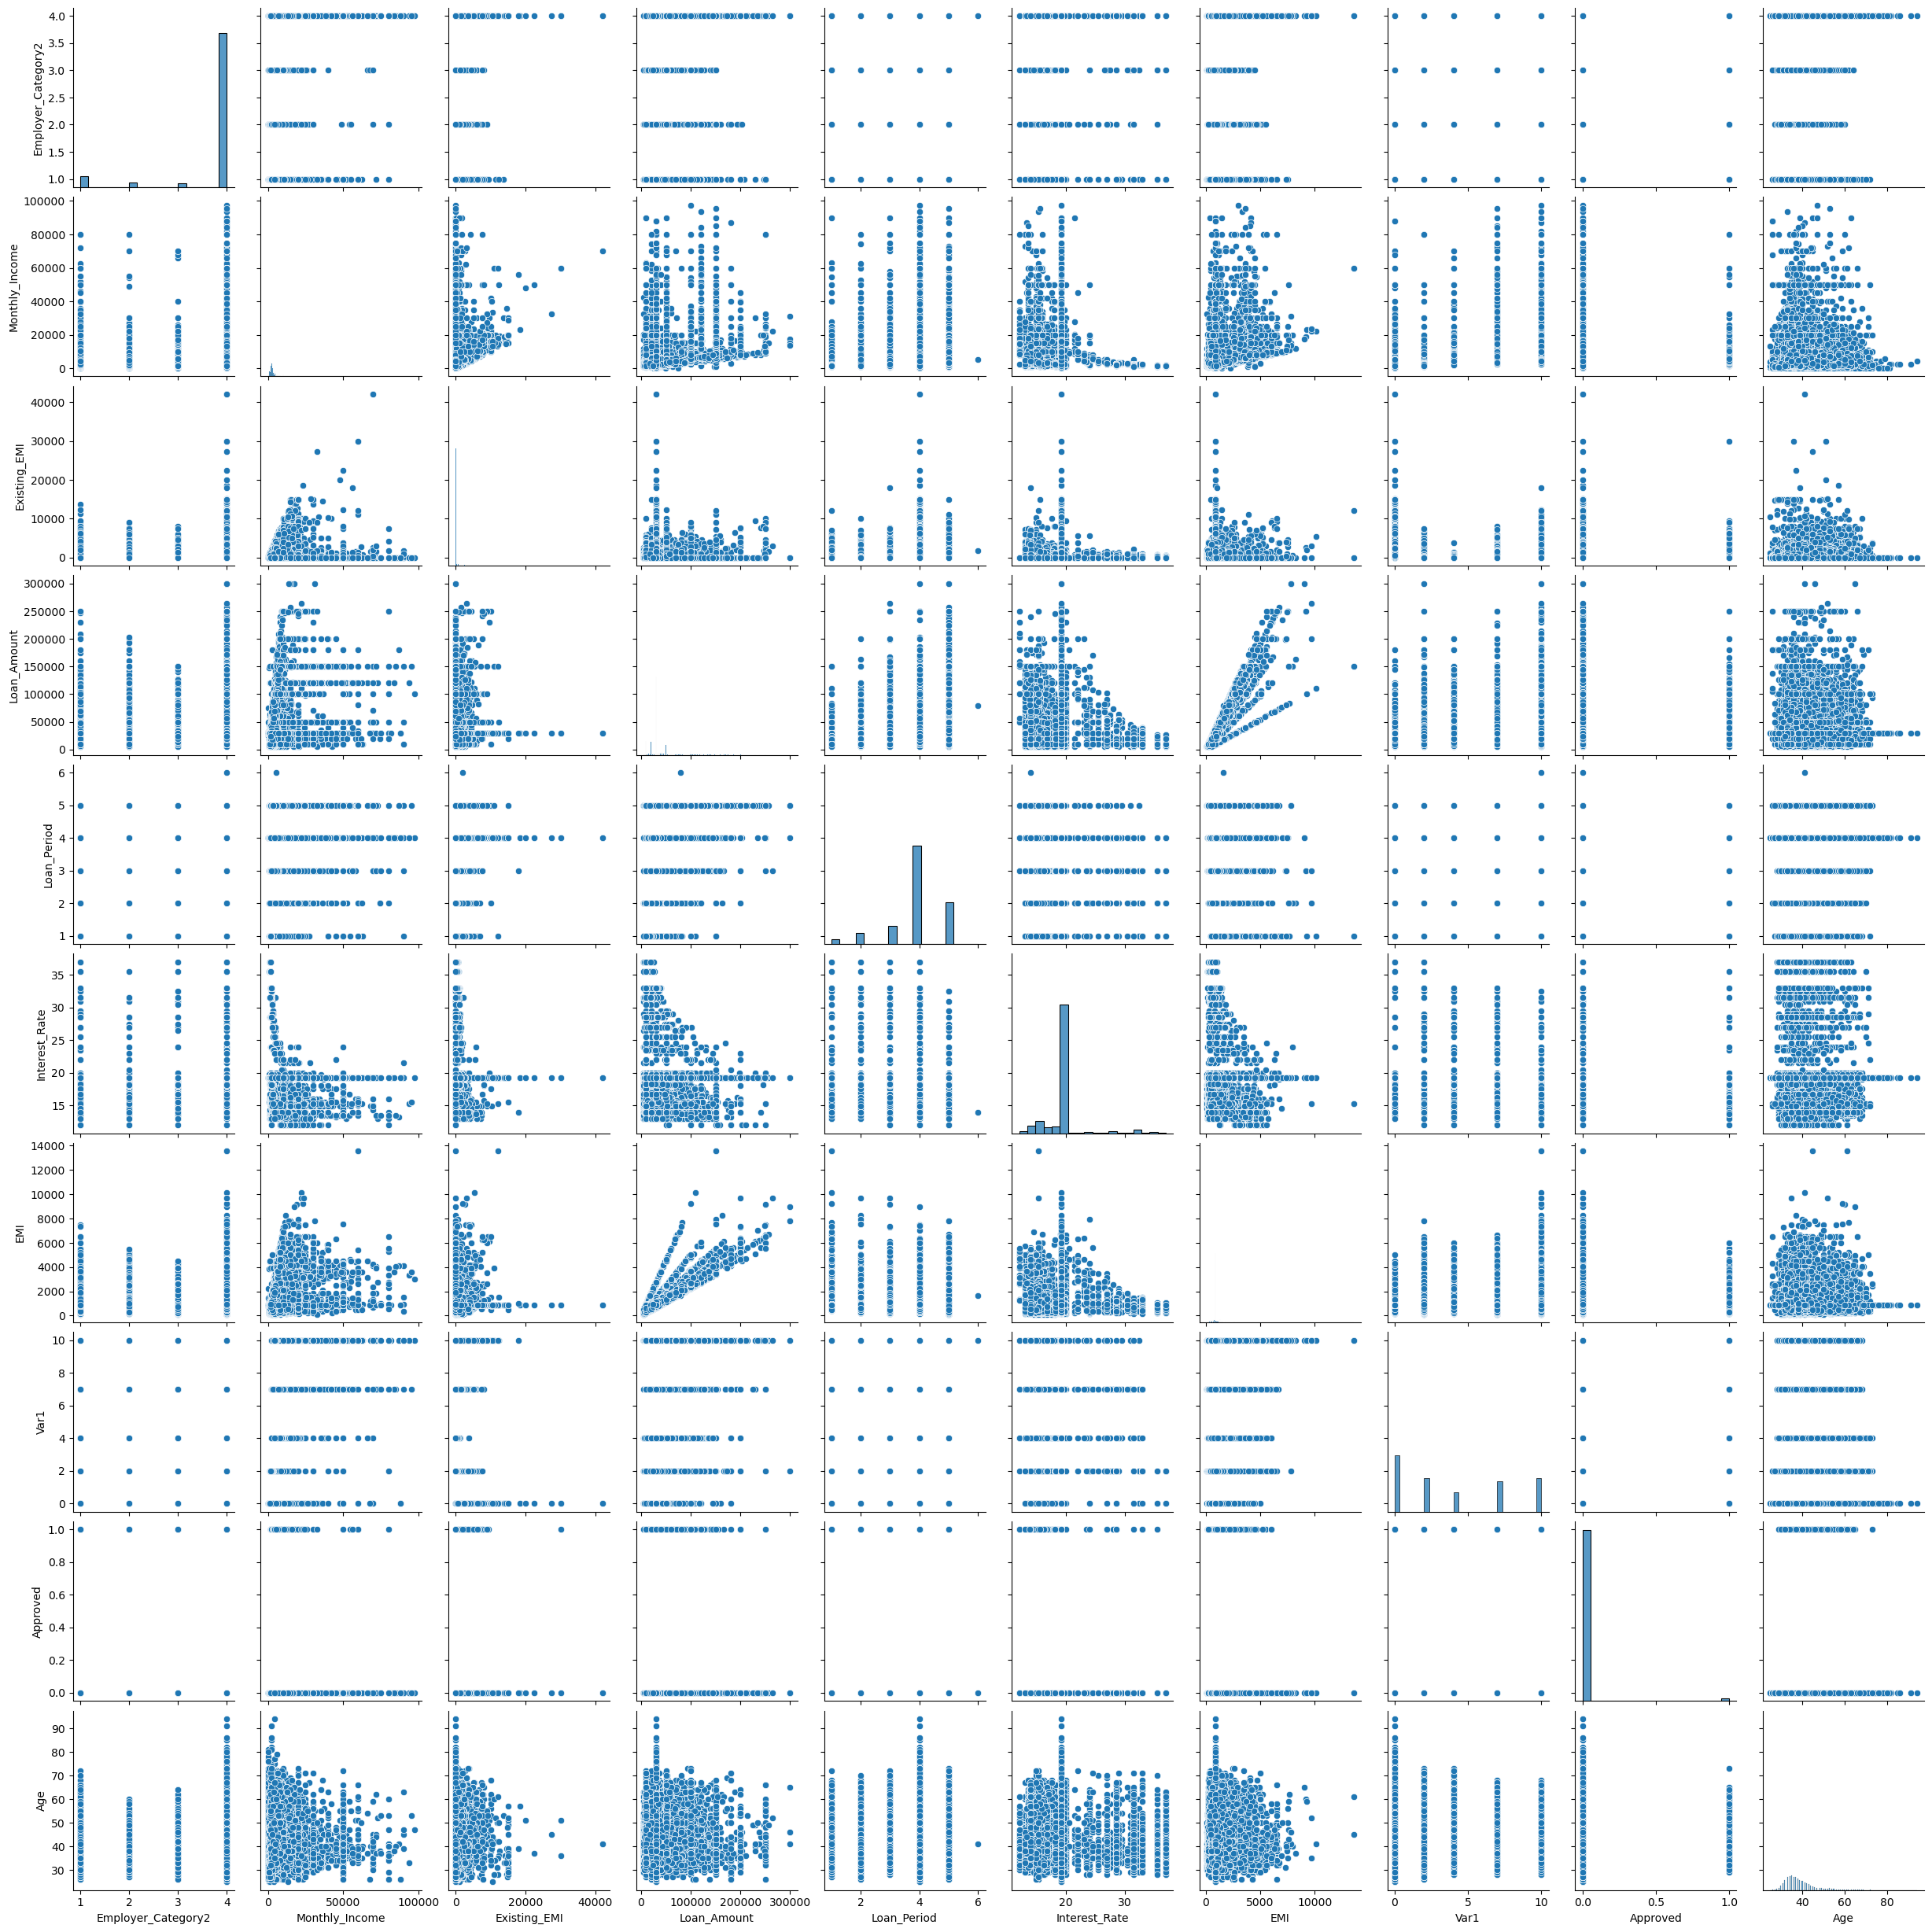

In [7]:
sns.pairplot(dleads)

## Create Total_Loan features

In [ ]:
# Total loan repayment = P(1 + i)^n

In [22]:
def total_loan_calc(data):
    # Assuming 'Interest_Rate' is in percentage and needs to be converted to a fraction
    total_repayment = data['Loan_Amount'] * (1 + data['Interest_Rate']/100)**data['Loan_Period']
    return total_repayment

# Applying the function to the DataFrame
dleads['Total_Loan'] = total_loan_calc(dleads[['Loan_Amount', 'Interest_Rate', 'Loan_Period']])
dleads.head()

,Gender,City_Category,Employer_Category1,Employer_Category2,Monthly_Income,Primary_Bank_Type,Contacted,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved,Age,Total_Loan
0,Female,A,A,4.0,2000.0,P,N,G,0.0,30000.0,4.0,19.21357,900.387994,0,0,45,60593.219140
1,Male,A,C,1.0,3500.0,P,Y,G,0.0,20000.0,2.0,13.25000,953.000000,10,0,38,25651.125000
2,Male,C,C,4.0,2250.0,G,Y,B,0.0,45000.0,4.0,19.21357,1350.581991,0,0,42,90889.828710
3,Male,C,A,4.0,3500.0,G,Y,B,0.0,92000.0,5.0,19.21357,2397.355046,7,0,35,221521.708014
4,Male,A,A,4.0,10000.0,P,Y,B,2500.0,50000.0,2.0,19.21357,2525.622064,10,0,39,71059.376076


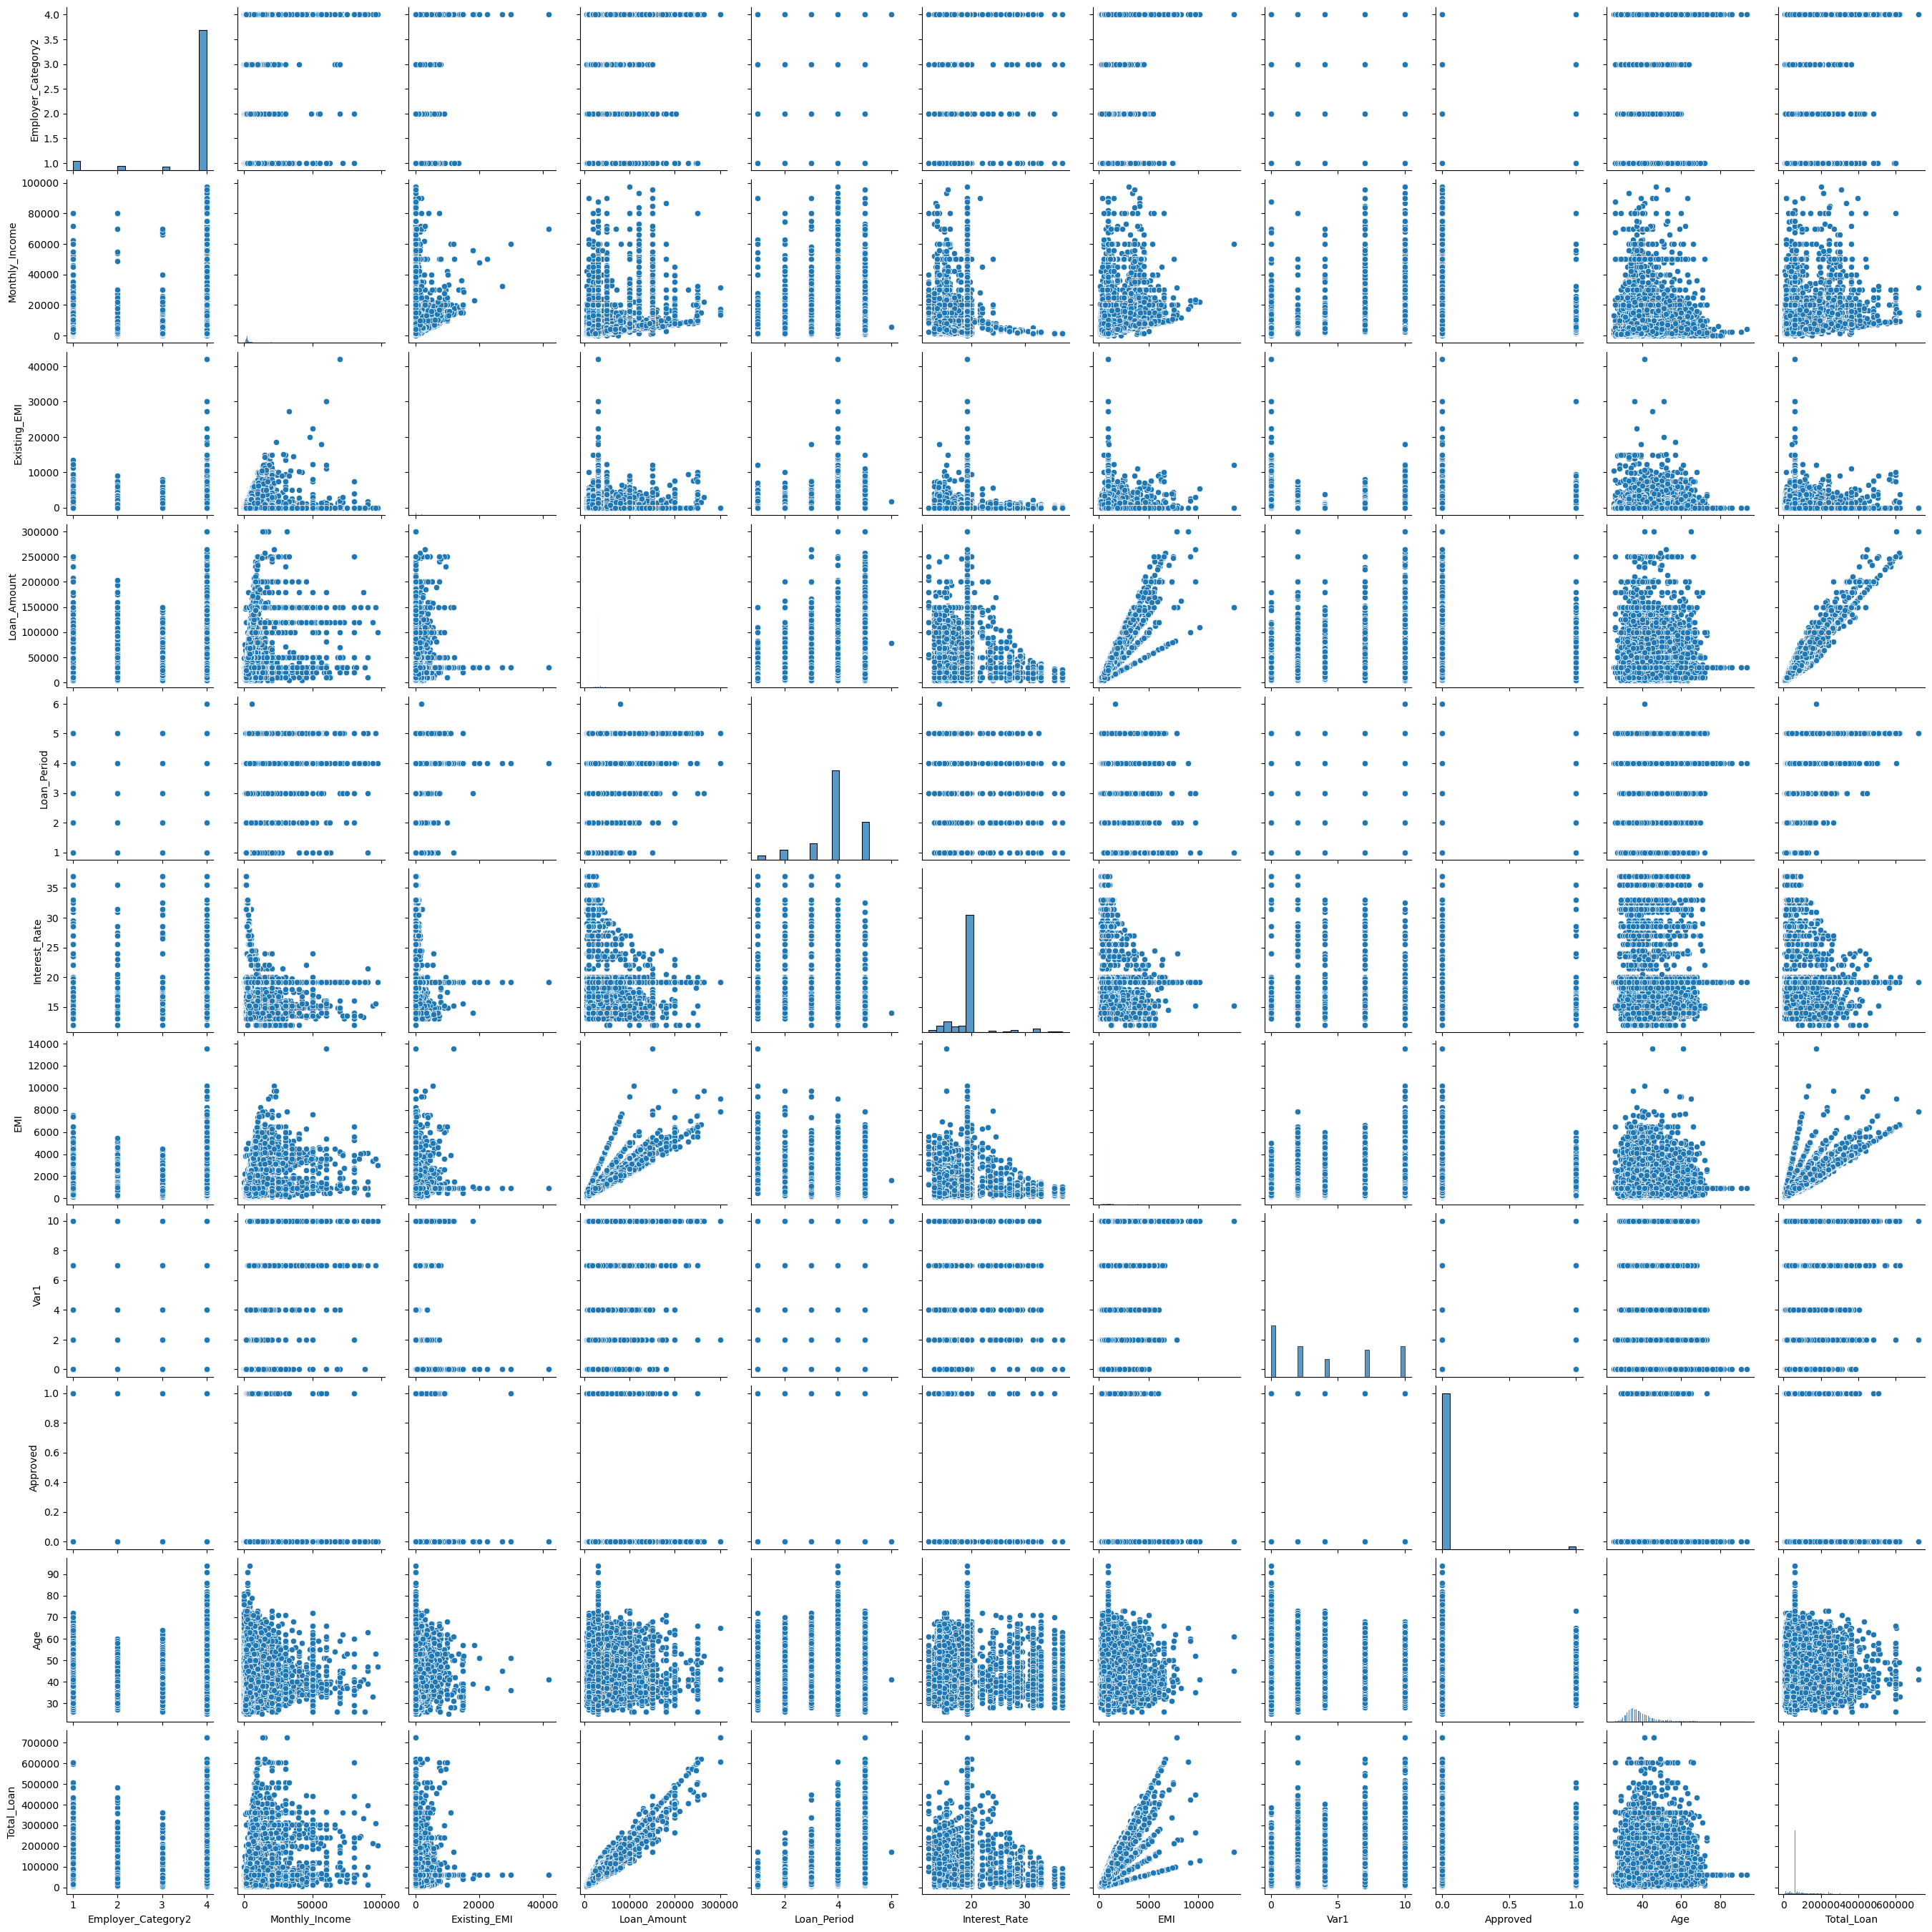

In [23]:
sns.pairplot(dleads)

# Drop EMI and Loan_Amount cols

In [28]:
eleads = dleads.drop(['EMI', 'Loan_Amount'], axis=1)

In [29]:
eleads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68797 entries, 0 to 68796
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              68797 non-null  object 
 1   City_Category       68797 non-null  object 
 2   Employer_Category1  68797 non-null  object 
 3   Employer_Category2  68797 non-null  float64
 4   Monthly_Income      68797 non-null  float64
 5   Primary_Bank_Type   68797 non-null  object 
 6   Contacted           68797 non-null  object 
 7   Source_Category     68797 non-null  object 
 8   Existing_EMI        68797 non-null  float64
 9   Loan_Period         68797 non-null  float64
 10  Interest_Rate       68797 non-null  float64
 11  Var1                68797 non-null  int64  
 12  Approved            68797 non-null  int64  
 13  Age                 68797 non-null  int64  
 14  Total_Loan          68797 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 7.9+

# Encode categorical features

In [30]:
def get_uniques(data):
    uniques = []
    for col in data.columns:
        uniques.append(data[col].nunique())

    table = pd.DataFrame({
        "Feature": data.columns,
        "Uniques": uniques
    })
    return table

get_uniques(eleads)

,Feature,Uniques
0,Gender,2
1,City_Category,3
2,Employer_Category1,3
3,Employer_Category2,4
4,Monthly_Income,4902
5,Primary_Bank_Type,2
6,Contacted,2
7,Source_Category,7
8,Existing_EMI,3189
9,Loan_Period,6


In [31]:
numeric_cont = dleads[['Monthly_Income', 'Existing_EMI', 'Interest_Rate', 'Total_Loan']]
numeric_disc = dleads[['Loan_Period', 'Age']]
# categoric_ord = dleads[['']]
categoric_bin = dleads[['Gender', 'Primary_Bank_Type', 'Contacted']]
categoric_nom = dleads[['City_Category', 'Employer_Category1', 'Employer_Category2', 'Source_Category', 'Var1']]
target = dleads['Approved']

In [32]:
le = LabelEncoder()

In [33]:
def encode_feats(data):
    # Label encode the categorical binary features 
    data['Gender'] = le.fit_transform(data['Gender'])
    data['Primary_Bank_Type'] = le.fit_transform(data['Primary_Bank_Type'])
    data['Contacted'] = le.fit_transform(data['Contacted'])

    # One-hot encode the categorical nominal features 
    categ = ['City_Category', 'Employer_Category1', 'Employer_Category2', 'Source_Category', 'Var1']
    data = pd.get_dummies(data, prefix_sep="_", columns=categ, dtype=int)

    return data

In [34]:
encoded_data = encode_feats(eleads)

# Scale data

In [35]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68797 entries, 0 to 68796
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  68797 non-null  int32  
 1   Monthly_Income          68797 non-null  float64
 2   Primary_Bank_Type       68797 non-null  int32  
 3   Contacted               68797 non-null  int32  
 4   Existing_EMI            68797 non-null  float64
 5   Loan_Period             68797 non-null  float64
 6   Interest_Rate           68797 non-null  float64
 7   Approved                68797 non-null  int64  
 8   Age                     68797 non-null  int64  
 9   Total_Loan              68797 non-null  float64
 10  City_Category_A         68797 non-null  int32  
 11  City_Category_B         68797 non-null  int32  
 12  City_Category_C         68797 non-null  int32  
 13  Employer_Category1_A    68797 non-null  int32  
 14  Employer_Category1_B    68797 non-null

In [36]:
encoded_data.head()

,Gender,Monthly_Income,Primary_Bank_Type,Contacted,Existing_EMI,Loan_Period,Interest_Rate,Approved,Age,Total_Loan,City_Category_A,City_Category_B,City_Category_C,Employer_Category1_A,Employer_Category1_B,Employer_Category1_C,Employer_Category2_1.0,Employer_Category2_2.0,Employer_Category2_3.0,Employer_Category2_4.0,Source_Category_A,Source_Category_B,Source_Category_C,Source_Category_D,Source_Category_E,Source_Category_F,Source_Category_G,Var1_0,Var1_2,Var1_4,Var1_7,Var1_10
0,0,2000.0,1,0,0.0,4.0,19.21357,0,45,60593.219140,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
1,1,3500.0,1,1,0.0,2.0,13.25000,0,38,25651.125000,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,1,2250.0,0,1,0.0,4.0,19.21357,0,42,90889.828710,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,1,3500.0,0,1,0.0,5.0,19.21357,0,35,221521.708014,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
4,1,10000.0,1,1,2500.0,2.0,19.21357,0,39,71059.376076,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [37]:
X = encoded_data.drop(['Approved'], axis=1)
y = encoded_data['Approved']

# Train test split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# LassoCV without scaling

In [39]:
lasso_cv = LassoCV(cv=4, random_state=42)
lasso_cv.fit(X_train, y_train)

LassoCV(cv=4, random_state=42)

In [40]:
y_preds = lasso_cv.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error {mse}")

Mean Squared Error 0.014457646608604808


In [41]:
# print(len(encoded_data.columns))
# print(len(lasso_cv.coef_))
lasso_coeff_table = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_cv.coef_
})

lasso_coeff_table

,Feature,Coefficient
0,Gender,0.000000e+00
1,Monthly_Income,8.764012e-07
2,Primary_Bank_Type,0.000000e+00
3,Contacted,0.000000e+00
4,Existing_EMI,7.538496e-06
5,Loan_Period,-0.000000e+00
6,Interest_Rate,-0.000000e+00
7,Age,0.000000e+00
8,Total_Loan,7.045416e-08
9,City_Category_A,0.000000e+00


In [42]:
print(len(X_test))
print(len(y_test))
print(len(y_preds))

20640
20640
20640


# Logistic regression without scaling

In [43]:
log_reg = LogisticRegression()

In [44]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [45]:
log_reg_y_preds = log_reg.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, log_reg_y_preds))

print("Confusion Matrix:")
print(confusion_matrix(y_test, log_reg_y_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20335
           1       0.00      0.00      0.00       305

    accuracy                           0.99     20640
   macro avg       0.49      0.50      0.50     20640
weighted avg       0.97      0.99      0.98     20640

Confusion Matrix:
[[20335     0]
 [  305     0]]


C:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
